# Real Time Analysis of Social Media Influence on Stocks and Cryptos 

### Note the target website to analyze the social influence is just reddit at the moment 
We start by importing all the necessary libraries.

In [1]:
###################### Install all necessary libraries #########################

from google.colab import files
!pip install praw -q
!pip install yfinance --upgrade --no-cache-dir -q
!pip install yahoo_fin -q
!pip install yahoo_fin --upgrade -q
!pip install requests_html -q
!pip install mpld3 -q
!pip install fastapi -q
!pip install colabcode -q

################################################################################

     |████████████████████████████████| 163kB 5.2MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 6.3MB 5.5MB/s 
     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 92kB 4.4MB/s 
     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 81kB 4.0MB/s 
ERROR: pyppeteer 0.2.5 has requirement urllib3<2.0.0,>=1.25.8, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 890kB 5.5MB/s 
     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 10.1MB 21.5MB/s 
     |████████████████████████████████| 747kB 5.1MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 8.3MB 7.8MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 430kB 30.3MB/s 
     |███

In [2]:
#########################################  DATA REQUESTS #############################################

# To provide current date and time in an format understandable by our API
from datetime import datetime 
from datetime import timedelta
# Properly display html docs before we could work on it
from lxml import html 
# Requests HTML data from websites and api 
import requests 
from requests import Request, Session

# Connecting with an API without any exceptions
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects 

# Clean the result from API's
import json  
from bs4 import BeautifulSoup

##########################################  DATA MINING ##############################################

# To get posts from reddit
import praw

# To get the current stock prices
import yfinance as yf  
from yahoo_fin.stock_info import get_data

# Connect to twitter API
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import tweepy

from urllib.request import urlopen

# Library to set up email alerts 
import smtplib

#######################################  DATA MANIPULATION ###########################################

import numpy as np
import pandas as pd
import csv
import re
from textblob import TextBlob
import string
import os
import time

#######################################  DATA VISUALIZATION ###########################################
 
import plotly.express as px 
import plotly.graph_objects as go
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import mpld3
import plotly

########################################### DATA TRANSFER ############################################

from fastapi import FastAPI
from colabcode import ColabCode 

#######################################################################################################

In [3]:
# Set api connection using fastapi
app = FastAPI()

## Set up connection to twitter (using tweepy library) and reddit (using praw library)

In [4]:
def Reddit_API(client_id, client_secret, username, password, subreddit, limit):
    """
    Receive the content of ``subreddit`` , establish credentials and retreive posts 
    parse the data by iterating over the list.
    
    Parameters
    ----------
    client_id     : str
    client_secret : str
    username      : str
    password      : str
    subreddit     : str
    limit         : int
    
    Returns
    -------
    pd.DataFrame
    """
    #################### Establishing Credentials for Reddit ###################

    client_auth = requests.auth.HTTPBasicAuth(client_id, client_secret)
    data = pd.DataFrame()
    params = {'limit': limit}
    data = {
        'grant_type': 'password',
        'username'  : username,
        'password'  : password
    }
    headers = {'User-Agent': 'data_analysis'}

    reddit = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=client_auth, data=data, headers=headers)

    
    ############################# Retrieving Data ##############################
    
    token = f"bearer {reddit.json()['access_token']}"
    headers = {**headers, **{'Authorization': token}}

    res_new = requests.get("https://oauth.reddit.com/r/"+subreddit+"/new",
                       headers=headers, params=params)
    res_top = requests.get("https://oauth.reddit.com/r/"+subreddit+"/top",
                       headers=headers, params=params)
    res_hot = requests.get("https://oauth.reddit.com/r/"+subreddit+"/hot",
                       headers=headers, params=params)
    res_rising = requests.get("https://oauth.reddit.com/r/"+subreddit+"/rising",
                       headers=headers, params=params)
    res_rec = requests.get("https://oauth.reddit.com/r/"+subreddit,
                       headers=headers, params=params)
    
    ############################### Parsing Data ###############################

    df = pd.DataFrame()
    posts = res_new.json()['data']['children']

    for post in posts:
      if post['data']['selftext']:
        df = df.append({'Title'       : post['data']['title'],
                        'Content'     : post['data']['selftext'],
                        'upvote_ratio': post['data']['upvote_ratio'],
                        'Upvotes'     : post['data']['ups'],
                        'score'       : post['data']['score'],
                        'type'        : post['data']['link_flair_css_class']
        }, ignore_index=True)
    
    posts = res_top.json()['data']['children']
    for post in posts:
      if post['data']['selftext']:
        df = df.append({'Title'       : post['data']['title'],
                        'Content'     : post['data']['selftext'],
                        'upvote_ratio': post['data']['upvote_ratio'],
                        'Upvotes'     : post['data']['ups'],
                        'score'       : post['data']['score'],
                        'type'        : post['data']['link_flair_css_class']
        }, ignore_index=True)

    posts = res_hot.json()['data']['children']
    for post in posts:
      if post['data']['selftext']:
        df = df.append({'Title'       : post['data']['title'],
                        'Content'     : post['data']['selftext'],
                        'upvote_ratio': post['data']['upvote_ratio'],
                        'Upvotes'     : post['data']['ups'],
                        'score'       : post['data']['score'],
                        'type'        : post['data']['link_flair_css_class']
        }, ignore_index=True)

    posts = res_rising.json()['data']['children']
    for post in posts:
      if post['data']['selftext']:
        df = df.append({'Title'       : post['data']['title'],
                        'Content'     : post['data']['selftext'],
                        'upvote_ratio': post['data']['upvote_ratio'],
                        'Upvotes'     : post['data']['ups'],
                        'score'       : post['data']['score'],
                        'type'        : post['data']['link_flair_css_class']
        }, ignore_index=True)

    posts = res_rec.json()['data']['children']
    for post in posts:
      if post['data']['selftext']:
        df = df.append({'Title'       : post['data']['title'],
                        'Content'     : post['data']['selftext'],
                        'upvote_ratio': post['data']['upvote_ratio'],
                        'Upvotes'     : post['data']['ups'],
                        'score'       : post['data']['score'],
                        'type'        : post['data']['link_flair_css_class']
        }, ignore_index=True)

    ############################################################################
    
    return df

In [5]:
def getDataReddit(client_id, client_secret, username, password, user_agent, title, lt):
    """
    Receive the content of ``title`` (subreddit), establish credentials and retreive posts 
    parse it using BeautifulSoup and return the DataFrame.

    Parameters
    ----------
    client_id     : str
    client_secret : str
    username      : str
    password      : str
    user_agent    : str
    title         : str
    lt            : int

    Returns
    -------
    pd.DataFrame
    """
    #################### Establishing Credentials for Reddit ###################
    
    reddit = praw.Reddit(client_id = client_id, 
                         client_secret = client_secret, 
                         username = username, 
                         password = password, 
                         user_agent = user_agent)
    
    ############## Using Credentials established to retreive data ##############
    
    subreddit = reddit.subreddit(title) 
    raw_data = subreddit.new(limit = lt)
    top_data = subreddit.top("week")
    
    ######################## Parsing the collected data ########################
    
    data = []
    
    for submission in top_data:
      try:
        value = Sentiment(BeautifulSoup(submission.selftext_html,"lxml")).analyze()
      except:
        value = 0

      data.append({'Title':submission.title,
                  'Content':BeautifulSoup(submission.selftext_html,"lxml").text,
                  'Upvotes':submission.ups,'Downvotes':submission.downs})
    
    for submission in raw_data:
      data.append({'Title':submission.title,
                  'Content':BeautifulSoup(submission.selftext_html,"lxml").text,
                  'Upvotes':submission.ups,'Downvotes':submission.downs})
    
    ############################################################################ 

    return pd.DataFrame(data)

In [6]:
def getDataTwitter(consumer_key, consumer_secret, access_key, access_secret, hashtags, target_date, total_tweets, attempts):
    """
    Receive the content of ``hashtags`` (tweets) by establishing credentials. 
    Parse the data we want to use and return the DataFrame.

    Parameters
    ----------
    consumer_key    : str
    consumer_secret : str
    access_key      : str
    access_secret   : str
    hashtags        : str
    target_date     : str
    total_tweets    : int
    attempts        : int

    Returns
    -------
    pd.DataFrame
    """
    ################### Establishing Credentials for Twitter ###################

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)

    ############################# Retrieving Data ##############################

    # create an empty DataFrame to store tweets later
    db_tweets = pd.DataFrame(columns = ['username', 'location', 'text', 'retweet_count'])
    count = 0

    # Collect all the tweets received in tweet_list for n attempts
    for i in range(0, attempts):
      tweets = tweepy.Cursor(api.search, q=hashtags, lang="en", since=target_date, tweet_mode='extended').items(total_tweets)
      tweet_list = [tweet for tweet in tweets]

    ######################## Parsing the collected data ########################

    for item in tweet_list:
      username, location, retweet_count = item.user.screen_name, item.user.location, item.retweet_count
      try:
        text = item.retweeted_status.full_text
      except AttributeError:
        text = item.full_text
      
      # Arrange and store the data collected for the tweet
      curr = [username, location, text, retweet_count]
      
      db_tweets.loc[len(db_tweets)] = curr
      count += 1

    ############################################################################

    # Good Night zzzzz
    time.sleep(900)
    return db_tweets

In [7]:
def clean(dataFrame):
    """
    Simply dropping duplicates from the dataframe.
    
    Parameters
    ----------
    dataFrame : pd.DataFrame
    
    Returns
    -------
    pd.DataFrame
    """
    dataFrame.drop_duplicates()
    return dataFrame

## Retreiveing and cleaning raw data from reddit and twitter
Note: We can also retrieve feeds from multiple subreddits  

In [8]:
# Enter your credentials 
client_id, client_secret = 'jA6tGV9IbyEDxg', 'ku7t8VHg5vtp3JMGjuqJmE5ybQhBxA'
username, password = '-betrayer', 'NarutoUzamaki$$$'

# We are currently using the normal API to retreive data
reddit_posts = pd.DataFrame()
reddit_crypto = pd.DataFrame()
subreddits_stocks = ["wallstreetbets", "stocks", "investing", "securityanalysis"]
for subreddit in subreddits_stocks:
  new_data = Reddit_API(client_id, client_secret, username, password, subreddit, 10000)
  reddit_posts = reddit_posts.append(new_data)
subreddits_crypto = ["Bitcoinmarkets", "Ethfinance", "CryptoMarkets", "CryptoCurrencyTrading", "ethtrader", "Cryptocurrency", "Crypto_Currency_News"]
for subreddit in subreddits_crypto:
  new_data = Reddit_API(client_id, client_secret, username, password, subreddit, 10000)
  reddit_crypto = reddit_crypto.append(new_data)
  
# To Use the praw library Uncomment the code below
# df = getDataReddit(client_id, client_secret, username, password, user_agent, 'stocks', 100) 
# df = clean(df)
# reddit_posts = reddit_posts.append(df)

In [9]:
# Size of our retrieved data
len(reddit_posts)

966

In [10]:
consumer_key, consumer_secret = '02tFL0DX18rEZN43uV9iCWr6E', 'Bx3xDbD3a9fuP5Kv90ZGHD5amoJXAhF3l5sEElnp6H4esWDk1e'
access_key, access_secret = '1189932019243003904-85tElnlmswS7Of3dkiIzdImn2J4xiA', '6xt9bsQxlxyBUnR2p71mYYbZ42nDJK7TWCQPeAtsIL5zj'
# df_tweets_crypto = getDataTwitter(consumer_key, consumer_secret, access_key, access_secret, hashtags="#Dogecoin OR #DogecoinToTheMoon OR #Dogearmy OR #doge", target_date='2021-04-30', total_tweets = 2500, attempts = 1)
# df_tweets = getDataTwitter(consumer_key, consumer_secret, access_key, access_secret, hashtags="#stocks OR #StockToBuy OR #trading OR #stockmarket OR #investing", target_date='2021-04-30', total_tweets = 2500, attempts = 1)

# We now retrieve the prices for Stocks and Crypto currency

### We will firstly retrieve data for Stocks (current prices, names and so on)

In [11]:
# You can find more info on how to use the yahoo finance API on the link provided below 
# https://algotrading101.com/learn/yahoo-finance-api-guide/
# Retrieveing all the stock names and their tickers from the given url
# We will need both for perfoming search on raw data and retrieving the prices from Yahoo Finance API 
# Using Beautiful Soup to get the html data organized 
# Soup stores th beautified version of html retrieved with stock information

In [12]:
def stocks():
    """
    Receive the content of ``stock_dataset_url``, parse it using beautiful soup and return it as a DataFrame.

    Returns
    -------
    pd.DataFrame
    """
    ############################## Retrieving Data #############################

    stock_dataset_url = 'https://stockanalysis.com/stocks/'
    page = requests.get(stock_dataset_url)
    soup = BeautifulSoup(page.text,'html.parser')
    review = soup.find_all(class_='no-spacing')
    review_stocks = review[0].find_all('a')
    
    ############################### Parsing Data ###############################
    
    stock_list = []
    all_stocks = []
    for item in review_stocks:
      res = item.text.split('-')
      stock_list.append({'Ticker':res[0],'Stock_Name':res[1]})
      all_stocks.append(res[1])
    
    ############################################################################

    return pd.DataFrame(stock_list)

In [13]:
# Get Top Gainers or Top Losers in the Stock Market Today
def Gainers_Or_Losers(x):
    """
    Receive the content of ``url``(Gainers if x == 1 else Losers), parse it as JSON and return the object.

    Parameters
    ----------
    x : int

    Returns
    -------
    pd.DataFrame 
    """
    ############################# Retrieving Data ##############################

    url2 = ("https://financialmodelingprep.com/api/v3/losers?apikey=71a14544ca8435ff9b1d2ad551cf5b4e#0")
    url1 = ("https://financialmodelingprep.com/api/v3/stock/gainers?apikey=71a14544ca8435ff9b1d2ad551cf5b4e")
    response = urlopen(url1 if x==1 else url2)
    data = response.read().decode("utf-8")

    ############################ Parsing Data(arr) #############################

    value = json.loads(data)
    try:
      arr = [item for item in value['mostGainerStock']]
    except:
      arr = [item for item in value]
    df = pd.DataFrame(arr)

    ############################################################################

    return df

In [57]:
# Retrieve data from the Yahoo Finance API using get_data(parm)
# Note: datetime is an inbuilt library we are using here 

d = get_data("amzn", start_date = datetime.now(), end_date = datetime.now(), index_as_date=False)

In [60]:
d['close'][0]

3386.489990234375

## Using the Crypto Api (Coin Base) we retreive data for crypto currency 

### The following functions are used below: 
#### CoinBase_Api() : Call for Api calls from coin base 
#### parseCrypto(data) : Call for parsing the data we retrieved from the API call earlier 
#### Alerts() : Call to check the current prices and send an email to everyone on the senders list about the top gainers in last 24h

In [15]:
def CoinBase_Api():
    """
    Receive the content of ``url``, parse it as JSON and return the data necessary as pd.DataFrame.

    Parameters
    ----------

    Returns
    -------
    pd.DataFrame 
    """
    ############################# Retrieving Data ##############################

    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
    parameters = {
      'start':'1',
      'limit':'5000',
      'convert':'USD'
    }
    headers = {
      'Accepts': 'application/json',
      'X-CMC_PRO_API_KEY': 'e5078d40-9c0f-45f5-8e1c-42c06a61b3c4',
    }

    session = Session()
    session.headers.update(headers)
    
    ############################# Parsing Data #################################

    try:
      response = session.get(url, params=parameters)
      data = json.loads(response.text)
      result = []
      for i in data['data']:
        result.append({'Name'              : i['name'],
                       'Symbol'            : i['symbol'],
                       'Price'             : i['quote']['USD']['price'],
                       'percent_change_1h' : i['quote']['USD']['percent_change_1h'],
                       'percent_change_24h': i['quote']['USD']['percent_change_24h'],
                       'percent_change_7d' : i['quote']['USD']['percent_change_7d'],
                       'percent_change_30d': i['quote']['USD']['percent_change_30d'],
                       'volume_24'         : i['quote']['USD']['volume_24h'],
                       'Trading_Volume'    : i['quote']['USD']['market_cap'],
                       'Circulating_Supply': i['circulating_supply']})
      return pd.DataFrame(result)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
      return e

    ############################################################################

In [16]:
def email_formatter(test_data):
    """
    Parse the DataFrame and convert it to a readable string 

    Parameters
    ----------
    test_data : pd.DataFrame

    Returns
    -------
    str
    """
    ############################ Formatting the Data ###########################
    
    count = 1

    str_send = "List of Cryptos with growth over 500% today. \n\n\n"
    str_send += "{:<8} {:<35} {:<15} {:<15} {:<15}".format('No.', 'Name','Symbol','Price','Percent Change')
    str_send += "\n"

    for index, row in test_data.iterrows():
      price = '{:.7f}'.format(row['Price'])
      str_send+="{:<8} {:<35} {:<15} {:<15} {:<15}".format(count,row['Name'], row['Symbol'], price, row['percent_change_24h'])
      str_send+="\n"
      count+=1
      
    

    ############################################################################

    return str_send

In [17]:
def Alerts(sender_email, sender_password, receiver_list):
    """
    Using the CoinBase_Api() email the top performing crytos and 
    stocks to the receiver list provided. 

    Parameters
    ----------
    sender_email    : str
    sender_password : str
    receiver_list   : list

    Returns
    -------
    E-mail
    """
    ############################ Collecting Data ###############################

    crypto_data = CoinBase_Api()
    stocks_gainers = Gainers_Or_Losers(1)
    stocks_losers = Gainers_Or_Losers(0)
    
    # Get the cryptos where growth is over 500% and stocks where growth is over 10% in last 24h 
    test_data = crypto_data.sort_values('percent_change_24h', ascending=False)
    test_data = test_data[test_data['percent_change_24h']>500]

    # Check whether there is any data to post or not 
    to_post = len(test_data) > 0 

    ################ E-mailing Results if Crypto growth > 500 ##################

    if to_post:
        # creates SMTP session
        s = smtplib.SMTP('smtp.gmail.com', 587)

        # start TLS for security
        s.starttls()

        # Authentication
        s.login(sender_email, sender_password)

        # Output Message
        TEXT = email_formatter(test_data)
        TEXT += "\n\n The Top Stock Gainers in the market today are : \n" + stocks_gainers.to_string() +"\n\n The top Stock Losers in the market today are : \n" + stocks_losers.to_string()
        TEXT += "\n\n Have a good day \n Regards,\n Vrajesh" 
        output_message = 'Subject: {}\n\n{}'.format("Crypto Alerts", TEXT)

        # sending the mail
        for receiver_email in receiver_list:
          s.sendmail(sender_email, receiver_email, output_message)

        # terminating the session
        s.quit()

    ############################################################################

In [18]:
# Establish Credentials 
sender_email = 'cryptoalerts167@gmail.com'
sender_password = 'Kaboom001$$@'
receiver_list = [ "harshghodkar@gmail.com"]
Alerts(sender_email, sender_password, receiver_list)

### We get a list of some common words in sentences so that we can remove them from stock occurences 

In [19]:
def Common_words():
    """
    Get a list of common vocab words in english to eliminte common vocab 
    similar to stock names from our list. 

    Returns
    -------
    List
    """
    ############################# Retrieving Data ##############################

    page = requests.get('https://www.ef.com/ca/english-resources/english-vocabulary/top-3000-words/')
    word_html = BeautifulSoup(page.text,'html.parser').find_all('p')[11]
    
    ############################# Parsing Data #################################
    
    counter = 0
    words = []
    for item in word_html:
      if counter%2 == 0:
        words.append(item)
      counter+=1
    
    ############################################################################
    
    return words 

# Data Visualization of stocks and cryptos based on the top 20 most popular   

## Defining helpful functions for Data Visualization
Combined_Analysis_Stocks(dataFrame, timePeriod) 

Individual_Analysis_line(dataFrame, timePeriod)

Individual_Analysis_Candle(dataFrame, timePeriod)

In [20]:
@app.get("/3d")
def ret_Graph(path):
    """
    Return the graphs to react by send html generated as string.   

    Parameters
    ----------
    path : str

    Returns
    -------
    str (app)
    """
    if os.access(path,os.R_OK):
      with open(path) as file:
        return file.read()

In [21]:
def Analyze_Stocks(stocks, amt, time):
    """
    Get the line plots of top ```amt``` treding stocks for the last ```time``` days.  

    Parameters
    ----------
    stocks : pd.DataFrame
    amt    : int
    time   : int

    Returns
    -------
    Graphs
    """
    ######################## Get the Top ```amt``` values ######################

    try:
      top_stocks = stocks.sort_values('Number_Of_Occurences', ascending=False).head(amt)
    except:
      top_stocks = stocks
    
    ############################ Collect Data and Plot #########################
    
    # Create an empty data Frame to store retreived data
    data_stock = pd.DataFrame(columns=top_stocks.columns)

    for tick in top_stocks['Ticker']:
      tick = tick.replace(" ","")
      try:
        
        # Collect data from yahoo finance function get_data using the stock ticker
        # Use pd.concat to store all data in one DataFrame
        data_stock = pd.concat([get_data(tick,
                              datetime.now() - timedelta(days=time),
                              datetime.date(datetime.now()), 
                              index_as_date=True),data_stock],
                            axis = 0)
      
      except:
        pass
    
    # Plot the line graph of all the stocks togather
    fig = px.line(data_stock, 
                  x=data_stock.index, 
                  y=data_stock['close'], 
                  color="ticker")
    
    fig.update_traces(mode="markers+lines")
    fig.update_xaxes(title="Date")
    fig.update_layout(
        hoverlabel=dict(
          bgcolor="white",
          font_size=16,
          font_family="Rockwell"
          )
    ) 
    plotly.offline.plot(fig, filename='AnalyzeStocks.html')
    ret_Graph('./AnalyzeStocks.html')
    # Display result (graph)
    fig.show()
    
    ############################################################################

In [22]:
def Individual_Analysis_line(stocks, amt, time):
    """
    Get the line plots of top ```amt``` treding stocks for the last ```time``` days.  

    Parameters
    ----------
    stocks : pd.DataFrame
    amt    : int
    time   : int

    Returns
    -------
    Graphs
    """
    ######################## Get the Top ```amt``` values ######################
    
    try:
      top_stocks = stocks.sort_values('Number_Of_Occurences', ascending=False).head(amt)
    except:
      top_stocks = stocks 
    
    ############################ Collect Data and Plot #########################
    
    for tick in top_stocks['Ticker']:
      tick = tick.replace(" ", "")
      try:
        # Collect data from yahoo finance function get_data using the stock ticker
        data_stock = get_data(tick,
                              datetime.now() - timedelta(days= time),
                              datetime.date(datetime.now()),
                              index_as_date=True)
        
        # Start plotting the line graph in plotly.express
        fig = px.line(data_stock, 
                      x=data_stock.index, 
                      y=data_stock['close'], 
                      color="ticker")
        
        fig.update_traces(mode="markers+lines")
        fig.update_layout(
            hoverlabel=dict(
                bgcolor="white",
                font_size=16,
                font_family="Rockwell"
            )
        ) 
        fig.update_xaxes(title= tick)
        plotly.offline.plot(fig, filename='IndividualLine.html')
        ret_Graph('./IndividualLine.html')
        # Display the result (graph)
        fig.show()
      except:
        pass
  
    ############################################################################

In [23]:
def Individual_Analysis_Candle(stocks, amt, time):
    """
    Get the plots of top ```amt``` treding stocks for the last ```time``` days.  

    Parameters
    ----------
    stocks : pd.DataFrame
    amt    : int
    time   : int

    Returns
    -------
    Graphs
    """
    ######################## Get the Top ```amt``` values ######################
    
    try:
      top_stocks = stocks.sort_values('Number_Of_Occurences', ascending=False).head(amt)
    except:
      top_stocks = stocks
    
    ############################ Collect Data and Plot #########################
    
    for tick in top_stocks['Ticker']:
      tick = tick.replace(" ", "")
      try:
        # Collect data from yahoo finance function get_data using the stock ticker
        df = get_data(tick,
                      datetime.now() - timedelta(days= time),
                      datetime.date(datetime.now()), 
                      index_as_date=True)
        
        # Start plotting the graphs in plotly.graph.objects
        fig = go.Figure(data=[go.Candlestick(x=df.index,
                  open=df['open'],
                  high=df['high'],
                  low=df['low'],
                  close=df['close'])])
        
        fig.update_layout(
          yaxis_title=tick,
          xaxis_title = 'Date'
        )
        plotly.offline.plot(fig, filename='IndividualAnalysis.html')
        ret_Graph('./IndividualAnalysis.html')
        # Display the result
        fig.show()

      except:
        pass

    ############################################################################

In [24]:
def popular_crypto(crypto_data, amt):
    """
    Get the growth rate of most popular ```amt``` crypto's in the last 24h and plot their graphs

    Parameters
    ----------
    crypto_data : pd.DataFrame
    amt         : int

    Returns
    -------
    Graph
    """
    ############################ Collect Data Req ##############################
    
    popular_crypto_data = crypto_data.sort_values('volume_24', ascending=False).head(amt)
    
    ################################## Plot 1 ##################################

    ax = plt.subplots(figsize=(13,7))
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(data=popular_crypto_data,
                x=popular_crypto_data['Name'],
                y=popular_crypto_data['percent_change_24h'],
                palette="Blues_d", 
                label = "percent_change_24h")
    plt.xticks(rotation='vertical')
    plt.title('Most Popular Crypto')
    
    # Display the result
    plt.show() 
    
    ############################################################################

In [25]:
def top_crypto(crypto_data, amt, period):
    """
    Get the top ```amt``` crypto with maximum growth in the last 24h and plot their graphs

    Parameters
    ----------
    crypto_data : pd.DataFrame
    amt         : int
    period      : int

    Returns
    -------
    Graphs
    """
    ########################### Collect Data Req ###############################

    top_crypto_data = crypto_data.sort_values('percent_change_24h'if period == 24 else 'percent_change_7d', ascending=False).head(amt)
    
    ################################# Plot 1 ###################################
    f, ax = plt.subplots(figsize=(13,7))

    if period == 24:
      sns.barplot(data=top_crypto_data,
                  x=top_crypto_data['Name'],
                  y=top_crypto_data['percent_change_24h'],
                  palette="gist_earth",#YlOrRd_r
                  label = "percent_change_24h")
    else:
      sns.barplot(data=top_crypto_data,
                  x=top_crypto_data['Name'],
                  y=top_crypto_data['percent_change_7d'],
                  palette="gist_earth",#YlOrRd_r
                  label = "percent_change_7d")
    
    plt.xticks(rotation='vertical')
    plt.title('Top Crypto\'s')
    ax.legend(fontsize = 14)
    
    ################################# Plot 2 ###################################

    if period == 24:
      fig = px.bar(top_crypto_data, x='Name', y='percent_change_24h',
                  hover_data=['Name', 'percent_change_24h','Price', 'Circulating_Supply', 'Trading_Volume', 'volume_24'], 
                  color='Name',
                  labels={'pop':'Crypto Currencies'},
                  height=500, 
                  template = 'ggplot2', title = 'Top Crypto\'s')
    else:
      fig = px.bar(top_crypto_data, x='Name', y='percent_change_7d',
                  hover_data=['Name', 'percent_change_7d','Price', 'Circulating_Supply', 'Trading_Volume', 'volume_24'], 
                  color='Name',
                  labels={'pop':'Crypto Currencies'},
                  height=500, 
                  template = 'ggplot2', title = 'Top Crypto\'s')
    plotly.offline.plot(fig, filename='topCrypto.html')
    ret_Graph('./topCrypto.html')
    fig.show()
    
    ############################################################################

In [26]:
def top_crypto_liquid(crypto_data, amt, period):
    """
    Get the top ```amt``` crypto with maximum growth in the last 24h and plot their graphs

    Parameters
    ----------
    crypto_data : pd.DataFrame
    amt         : int
    period      : int

    Returns
    -------
    Graphs
    """
    ########################### Collect Data Req ###############################

    top_crypto_data = crypto_data.sort_values('percent_change_24h' if period == 24 else 'percent_change_7d', ascending=False).head(amt) 
    
    ################################# Plot 1 ###################################
    f, ax = plt.subplots(figsize=(13,7))

    if period == 24:
      sns.barplot(data=top_crypto_data,
                  x=top_crypto_data['Name'],
                  y=top_crypto_data['percent_change_24h'],
                  palette="gist_earth",#YlOrRd_r
                  label = "percent_change_24h")
    else:
      sns.barplot(data=top_crypto_data,
                  x=top_crypto_data['Name'],
                  y=top_crypto_data['percent_change_7d'],
                  palette="gist_earth",#YlOrRd_r
                  label = "percent_change_7d")
    
    plt.xticks(rotation='vertical')
    plt.title('Top Crypto\'s')
    ax.legend(fontsize = 14)
    
    ################################# Plot 2 ###################################

    if period == 24:
      fig = px.bar(top_crypto_data, x='Name', y='percent_change_24h',
                  hover_data=['Name', 'percent_change_24h','Price', 'Liquidity', 'Circulating_Supply', 'Trading_Volume', 'volume_24'], 
                  color='Name',
                  labels={'pop':'Crypto Currencies'},
                  height=500, 
                  template = 'ggplot2', title = 'Top Crypto\'s')
    else:
      fig = px.bar(top_crypto_data, x='Name', y='percent_change_7d',
                  hover_data=['Name', 'percent_change_7d','Price', 'Liquidity', 'Circulating_Supply', 'Trading_Volume', 'volume_24'], 
                  color='Name',
                  labels={'pop':'Crypto Currencies'},
                  height=500, 
                  template = 'ggplot2', title = 'Top Crypto\'s')
    plotly.offline.plot(fig, filename='bestCrypto.html')
    ret_Graph('./bestCrypto.html')
    fig.show()
    
    ############################################################################

In [104]:
# To get the number of posts of a stock subreddit we choose 
def Analyze_Reddit_Posts(stocks,df, common_words):
    """
    Count the total occurences and upvotes of every stock on reddit by 
    crossreferencing it with the DataFrame of reddit post we retreived earlier.

    Parameters
    ----------
    stocks       : pd.DataFrame
    df           : pd.DataFrame
    common_words : list

    Returns
    -------
    pd.DataFrame
    """
    ############################ Analyze Reddit Posts ##########################

    result = [] 
    
    for stock in stocks.itertuples():
      sum ,count = 0, 0
      stock_ = stock.Stock_Name
      for item in df.itertuples():

        # If the stock name occurred in either Title or Content of the post 
        if stock_ in item.Title or stock_ in item.Content:
          sum = sum + item.Upvotes
          count = count + 1
    
      # Append data if the stock:
      #                           Occurred More than once
      #                           Not a common word 
      #                           The name is of len > 4

      if count > 0 and len(stock.Stock_Name)>4 and stock_ not in common_words:
        result.append({'Name' : stock.Stock_Name,
                       'Ticker' : stock.Ticker,
                       'Number_Of_Occurences' : count,
                       'Total_Upvotes' : sum})
    
    ############################################################################

    return pd.DataFrame(result)

In [28]:
# To get the number of posts of a stock subreddit we choose 
def Analyze_Reddit_Crypto(cryptos,df, common_words):
    """
    Count the total occurences and upvotes of every crypto on reddit by 
    crossreferencing it with the DataFrame of reddit post we retreived earlier.

    Parameters
    ----------
    cryptos      : pd.DataFrame
    df           : pd.DataFrame
    common_words : list

    Returns
    -------
    pd.DataFrame
    """
    ############################ Analyze Reddit Posts ##########################

    result = [] 
    
    for crypto in cryptos.itertuples():
      sum ,count = 0, 0
      crypto_ = crypto.Name
      for item in df.itertuples():

        # If the stock name occurred in either Title or Content of the post 
        if crypto_ in item.Title or crypto_ in item.Content:
          sum = sum + item.Upvotes
          count = count + 1
    
      # Append data if the stock:
      #                           Occurred More than once
      #                           Not a common word 
      #                           The name is of len > 4

      if count > 0 and len(crypto_)>4 and crypto_ not in common_words:
        result.append({'Name' : crypto_,
                       'Symbol' : crypto.Symbol,
                       'Number_Of_Occurences' : count,
                       'Total_Upvotes' : sum})
    
    ############################################################################

    return pd.DataFrame(result)

In [105]:
def Analyze_tweets(stocks, df, common_words):
    """
    Count the total occurences and retweets of every stock on twitter by 
    crossreferencing it with the DataFrame of tweets we retreived earlier.

    Parameters
    ----------
    stocks       : pd.DataFrame
    df           : pd.DataFrame
    common_words : list

    Returns
    -------
    pd.DataFrame
    """
    ############################### Analyze Tweets #############################
    
    result = []
    for stock in stocks.iterrows():
      sum, count = 0, 0
      stock_ = stock[1]['Stock_Name']
      for item in df.itertuples():
        if stock_ in item.text:
          sum = sum + item.retweet_count
          count = count + 1
      
      # Append data if the stock:
      #                           Occurred More than once
      #                           Not a common word 
      #                           The name is of len > 4

      if count > 0 and len(stock_) > 4 and stock_ not in common_words:
        result.append({'Name' : stock_, 
                       'Ticker': stock[1]['Ticker'], 
                       'Number_Of_Occurences' : count, 
                       'Total_retweets' : sum})
        
    ############################################################################
    return pd.DataFrame(result)

In [30]:
# To get the number of posts of a stock subreddit we choose 
def Analyze_Tweets_Crypto(cryptos,df, common_words):
    """
    Count the total occurences and upvotes of every crypto on reddit by 
    crossreferencing it with the DataFrame of reddit post we retreived earlier.

    Parameters
    ----------
    cryptos      : pd.DataFrame
    df           : pd.DataFrame
    common_words : list

    Returns
    -------
    pd.DataFrame
    """
    ############################ Analyze Reddit Posts ##########################

    result = [] 
    
    for crypto in cryptos.itertuples():
      sum ,count = 0, 0
      crypto_ = crypto.Name
      for item in df.itertuples():

        # If the stock name occurred in either Title or Content of the post 
        if crypto_ in item.text:
          sum = sum + item.retweet_count
          count = count + 1
    
      # Append data if the stock:
      #                           Occurred More than once
      #                           Not a common word 
      #                           The name is of len > 4

      if count > 0 and len(crypto_)>4 and crypto_ not in common_words:
        result.append({'Name' : crypto_,
                       'Symbol' : crypto.Symbol,
                       'Number_Of_Occurences' : count,
                       'Total_Retweets' : sum})
    
    ############################################################################

    return pd.DataFrame(result)

In [31]:
def crypto_liquidity(crypto_data):
    """
    Get the current liquidity of all the stocks in the market. To actually analyze
    the crypto that has a steady demand in the market.

    Parameters
    ----------
    crypto_data : pd.DataFrame 
    
    Returns
    -------
    pd.DataFrame
    """
    ############################# Retrieving Data ##############################
    
    page = requests.get('https://coinmarketcap.com/exchanges/digifinex/')
    soup = BeautifulSoup(page.text, 'lxml')
    review = soup.find_all(class_='cmc-table-row')

    ############################### Parsing Data ###############################
    
    data = []
    for item in review:
      # Using Regex for parsing 
      regex = re.compile('[0-9]+')
      regex1 = re.compile('[A-Z][a-z]+')
      regex2 = re.compile('%[0-9]+')
      str_0 = item.text

      try:
        name = regex1.findall(str_0)[0]
      except:
        name = ""
      try:
        liquidity = regex2.findall(str_0)[0]
      except:
        liquidity = -1
      
      try:
        data.append({'Name': name, 'Liquidity': int(liquidity[1:])})
      except:
        data.append({'Name': name, 'Liquidity': liquidity})

    ########################### Merge Data Frames ##############################

    data = pd.DataFrame(data)
    data = data[data.Liquidity > 0]
    data = data.groupby('Name', group_keys=False).apply(lambda x: x.loc[x.Liquidity.idxmax()])
    data.reset_index(drop=True, inplace=True)
    data = pd.merge(left=crypto_data, right=data, how='left', left_on='Name', right_on='Name')
    data = data[data.Liquidity.notnull()]
    
    ############################################################################

    return data

In [32]:
from plotly.graph_objs import Scatter3d, Layout, Scene
from plotly.offline import iplot

In [33]:
def Display_3d(liquidable, time):
    """
    Represent the Top Most Promising Cryptos in a 3d scatter plot. 

    Parameters
    ----------
    liquidable : pd.DataFrame 
    time       : int
    
    Returns
    -------
    Graph
    """
    ############################ Get the Data we require #######################
    
    liquidable = liquidable.sort_values('percent_change_24h' if time == 24 else 'percent_change_7d', ascending=False).head(20)
    
    ############################### Plot 1 #####################################
    
    fig = px.scatter_3d(liquidable, 
                        x='Price', 
                        y='Circulating_Supply', 
                        z='percent_change_24h' if time == 24 else 'percent_change_7d',
                        color='Name', 
                        opacity=0.8, 
                        hover_data = ['Name','Price'],
                        size = 'Liquidity', 
                        title = "Most Promising Crypto Currencies",
    )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), template = "plotly_dark")
    plotly.offline.plot(fig, filename='my3Dplot1.html')
    ret_Graph('./my3Dplot1.html')
    fig.show()

    ################################ Plot 2 ####################################
    
    percent_change, Circulating_Supply, Price = liquidable.percent_change_24h if time == 24 else liquidable.percent_change_7d, liquidable.Circulating_Supply, liquidable.Price

    layout = Layout(scene = Scene(
                                                            xaxis = {'title': 'Price'},
                                                            yaxis = {'title': 'Circulating Supply'},
                                                            zaxis = {'title': 'percent_change'}))
    
    fig = go.Figure(data=[go.Scatter3d(
        x=Price,
        y=Circulating_Supply,
        z=percent_change,
        mode='markers',
        marker=dict(
            size=8,
            color=Price,                
            colorscale='Viridis',
            opacity=0.5
        )
    )], layout = layout)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    plotly.offline.plot(fig, filename='my3Dplot2.html')
    ret_Graph('./my3Dplot2.html')
    fig.show()
    
    ############################################################################

### Most popular Crypto Currencies percent change in amount 

In [34]:
crypto_data = CoinBase_Api()
crypto_data = crypto_data[crypto_data.Circulating_Supply > 0]
crypto_data = crypto_data[crypto_data.volume_24 > 200000]

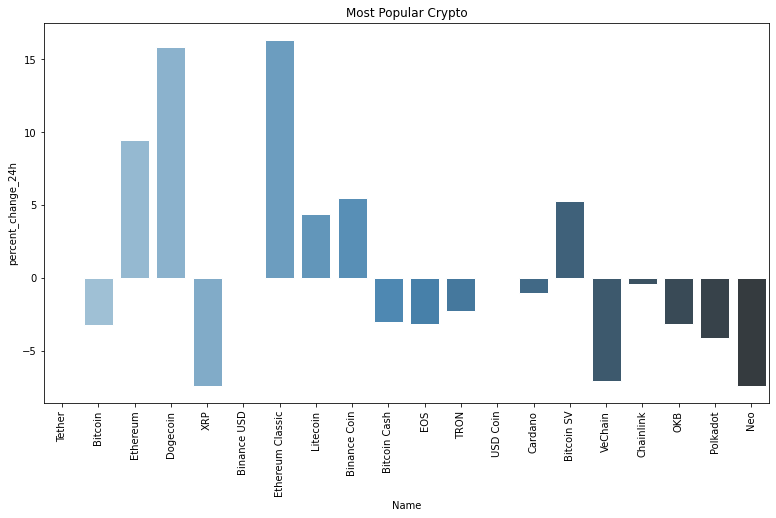

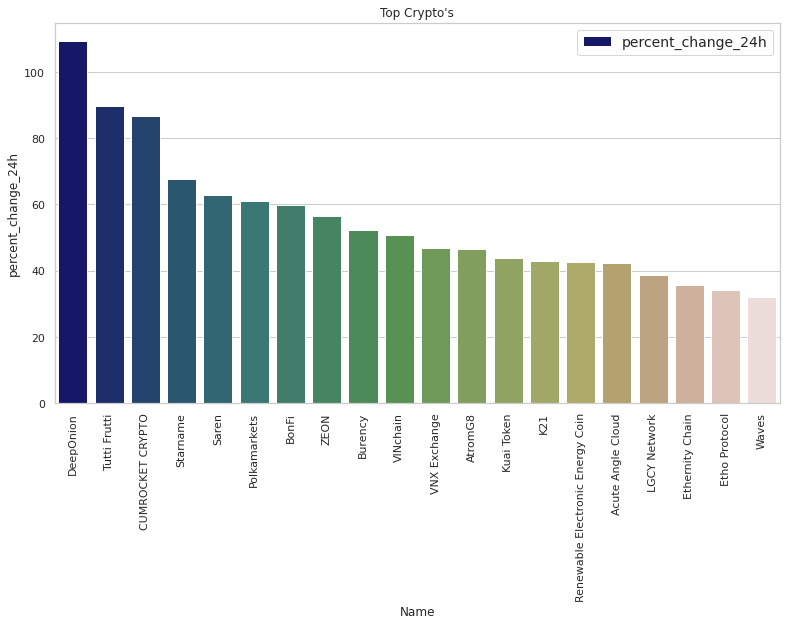

In [35]:
popular_crypto(crypto_data=crypto_data, amt=20)
top_crypto(crypto_data=crypto_data, amt = 20, period = 24)

### Trending Stocks on sub-reddit 'r/Stocks' 

In [36]:
stocks = stocks()
common_words = Common_words()

In [107]:
Analysis_reddit = Analyze_Reddit_Posts(stocks,reddit_posts, common_words)
# Analysis_tweets = Analyze_tweets(stocks,df_tweets, common_words) 
# result_twitter.sort_values('Number_Of_Occurences', ascending=False)
# index_names = result_twitter[ (result_twitter['Number_Of_Occurences'] >= 10)].index
# result_twitter.drop(index_names, inplace = True)

In [38]:
Analyze_Stocks(Analysis_reddit, 20, 365)
Individual_Analysis_Candle(Analysis_reddit, 10, 365)

In [39]:
# Crypto Analysis Reddit 
Analysis_Reddit_C = Analyze_Reddit_Crypto(crypto_data, reddit_crypto, common_words)
Analysis_Reddit_C = Analysis_Reddit_C.sort_values('Number_Of_Occurences', ascending=False)
Analysis_R = pd.merge(left=crypto_data, right=Analysis_Reddit_C, how='left', left_on='Name', right_on='Name')


In [110]:
def Analyze_Posts(data, parm1, parm2, parm3):
    """
    Count the total occurences and retweets of every stock on twitter by 
    crossreferencing it with the DataFrame of tweets we retreived earlier.

    Parameters
    ----------
    data  : pd.DataFrame
    parm1 : str
    parm2 : str
    parm3 : str

    Returns
    -------
    Graph
    """
    ################################# Plot 1 ###################################
    
    fig = px.scatter_3d(data.head(10), 
                        x=parm1, 
                        y=parm2, 
                        z=parm3,
                        color=parm2, 
                        opacity=0.8,
                        hover_data = ['Name','Price'], 
                        title = "Most Promising Crypto Currencies",
    )
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), template = "plotly_dark")
    fig.show()

    ############################################################################


In [41]:
Analyze_Posts(Analysis_R, 'Price', 'Total_Upvotes', 'Number_Of_Occurences')

In [42]:
Analysis_tweets = Analyze_Tweets_Crypto(crypto_data, df_tweets, common_words)
Analysis_tweets = pd.merge(left=crypto_data, right=df_t, how='left', left_on='Name', right_on='Name')
Analysis_tweets = Analysis_tweets.drop(columns='Symbol_y')

NameError: ignored

In [ ]:
Analyze_Posts(Analysis_tweets, 'Price', 'Total_Upvotes', 'Number_Of_Occurences')

In [ ]:
Analyze_Stocks(df_tweets, 20, 365)
Individual_Analysis_Candle(df_tweets, 20, 365)

## Top Gainers in the Stock Market

---



---



In [ ]:
# Use 1 as the parameter to get top gainers
top_gainers_today = Gainers_Or_Losers(1)
top_gainers_today.rename(columns={'ticker': 'Ticker'}, inplace=True)

In [ ]:
Analyze_Stocks(top_gainers_today, 20, 365)
Individual_Analysis_Candle(top_gainers_today, 20, 365)

## To get the most growing stocks that are also liquidable

In [ ]:
liquidable = crypto_liquidity(crypto_data)

In [ ]:
top_crypto_liquid(liquidable,20, 7)

In [ ]:
Display_3d(liquidable,7)

## We now attempt to cross reference the data to get a relationship between the social influence of the stocks and stock prices 

Note: Here, we conclude our data mining step of our project 